# 06: Small-Scale Training Test

**Purpose:** Test the training loop with a tiny dataset (10-20 events)

**What this does:**
- Train SGT model on small subset
- Verify training loop works
- Check for overfitting (model should memorize small dataset)
- Test validation and checkpointing
- Measure training speed

**What this does NOT do:**
- Train on full dataset (that's notebook 07)
- Run for many epochs
- Compute final metrics

**Expected time:** 10-20 minutes

---

**Prerequisites:**
- Run `01_Setup_and_Environment.ipynb` first
- Run `02_Data_Verification.ipynb` to check/download data
- Run `05_Test_Full_Model.ipynb` to verify model works

## Step 1: Setup

In [2]:
from google.colab import drive
import sys
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Mount Drive
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=False)
print("✅ Drive mounted\n")

# Install dependencies (each Colab session needs this!)
print("Installing dependencies...")
!pip install -q torch-geometric h5py pandas tqdm matplotlib lpips scikit-image scipy
print("✅ Dependencies installed\n")

# Clone/update repository
REPO_PATH = '/content/stormfusion-sevir'
if not os.path.exists(REPO_PATH):
    print("Cloning repository...")
    !git clone https://github.com/syedhaliz/stormfusion-sevir.git {REPO_PATH}
    print("✅ Repository cloned\n")
else:
    print("Repository exists, pulling latest changes...")
    !cd {REPO_PATH} && git pull
    print("✅ Repository updated\n")

# Add repository to path
if REPO_PATH not in sys.path:
    sys.path.insert(0, REPO_PATH)
    print(f"✅ Added {REPO_PATH} to Python path\n")

# Force reload of modules to get latest code
import importlib
for module_name in ['stormfusion.models.sgt', 'stormfusion.data.sevir_multimodal']:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])

print("✅ Modules reloaded\n")

# Paths
DRIVE_ROOT = "/content/drive/MyDrive/SEVIR_Data"
SEVIR_ROOT = f"{DRIVE_ROOT}/data/sevir"
CATALOG_PATH = f"{DRIVE_ROOT}/data/SEVIR_CATALOG.csv"
CHECKPOINT_DIR = f"{DRIVE_ROOT}/checkpoints/small_scale_test"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

Mounting Google Drive...
Mounted at /content/drive
✅ Drive mounted

Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.2 MB/s eta 0:00:00
✅ Dependencies installed

Cloning repository...
Cloning into '/content/stormfusion-sevir'...
remote: Enumerating objects: 553, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 553 (delta 62), reused 52 (delta 25), pack-reused 459 (from 1)
Receiving objects: 100% (553/553), 6.07 MiB | 5.83 MiB/s, done.
Resolving deltas: 100% (323/323), done.
✅ Repository cloned

✅ Added /content/stormfusion-sevir to Python path

✅ Modules reloaded

PyTorch version: 2.8.0+cu126
CUDA available: True
Using device: cuda



## Step 2: Load Small Dataset

In [3]:
from stormfusion.data.sevir_multimodal import SEVIRMultiModalDataset

print("="*70)
print("LOADING SMALL DATASET")
print("="*70)

# Load catalog
catalog = pd.read_csv(CATALOG_PATH, low_memory=False)
print(f"\nCatalog loaded: {len(catalog)} entries")

# Get small subset of event IDs (first 20 events: 16 train, 4 val)
all_event_ids = catalog['id'].unique()
train_event_ids = all_event_ids[:48]
val_event_ids = all_event_ids[48:60]

print(f"\nSmall dataset:")
print(f"  Train events: {len(train_event_ids)}")
print(f"  Val events: {len(val_event_ids)}")

# Build indices for train and val
vil_catalog = catalog[catalog['img_type'] == 'vil']

train_index = []
for event_id in train_event_ids:
    event_rows = vil_catalog[vil_catalog['id'] == event_id]
    if not event_rows.empty:
        row = event_rows.iloc[0]
        train_index.append((event_id, int(row['file_index'])))

val_index = []
for event_id in val_event_ids:
    event_rows = vil_catalog[vil_catalog['id'] == event_id]
    if not event_rows.empty:
        row = event_rows.iloc[0]
        val_index.append((event_id, int(row['file_index'])))

print(f"\nBuilt indices:")
print(f"  Train: {len(train_index)} samples")
print(f"  Val: {len(val_index)} samples")

# Create datasets
train_dataset = SEVIRMultiModalDataset(
    index=train_index,
    sevir_root=SEVIR_ROOT,
    catalog_path=CATALOG_PATH,
    input_steps=12,
    output_steps=12,
    normalize=True,
    augment=True
)

val_dataset = SEVIRMultiModalDataset(
    index=val_index,
    sevir_root=SEVIR_ROOT,
    catalog_path=CATALOG_PATH,
    input_steps=12,
    output_steps=12,
    normalize=True,
    augment=False
)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val: {len(val_dataset)} samples")

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"\nDataloader batches:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val: {len(val_loader)} batches")
print("\n" + "="*70)

LOADING SMALL DATASET

Catalog loaded: 76004 entries

Small dataset:
  Train events: 48
  Val events: 12

Built indices:
  Train: 48 samples
  Val: 12 samples

Dataset sizes:
  Train: 48 samples
  Val: 12 samples

Dataloader batches:
  Train: 24 batches
  Val: 6 batches



## Step 3: Create Model and Optimizer

In [4]:
from stormfusion.models.sgt import create_sgt_model

print("="*70)
print("CREATING MODEL")
print("="*70)

# Create model with config dict
config = {
    'modalities': ['vil', 'ir069', 'ir107', 'lght'],
    'input_steps': 12,
    'output_steps': 12,
    'hidden_dim': 128,
    'gnn_layers': 3,
    'transformer_layers': 4,
    'num_heads': 8,
    'use_physics': True
}

model = create_sgt_model(config).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,} ({total_params/1e6:.2f}M)")

# Create optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

print("\n✅ Model, optimizer, and scheduler created")
print("\n" + "="*70)

CREATING MODEL

Total parameters: 5,252,297 (5.25M)

✅ Model, optimizer, and scheduler created



## Step 4: Training Loop

In [5]:
print("="*70)
print("STARTING SMALL-SCALE TRAINING")
print("="*70)

num_epochs = 20
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': [], 'lr': []}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    # ============= TRAINING =============
    model.train()
    train_loss = 0.0

    pbar = tqdm(train_loader, desc='Training')
    for batch_idx, (inputs, outputs_dict) in enumerate(pbar):
        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        # Dataset returns outputs dict with 'vil' key
        targets = outputs_dict['vil'].to(device)

        # Forward pass (model returns tuple!)
        optimizer.zero_grad()
        predictions, attention_info, physics_info = model(inputs)

        # Compute loss using model's method
        loss, loss_dict = model.compute_loss(
            predictions=predictions,
            targets=targets,
            physics_info=physics_info,
            lambda_mse=1.0,
            lambda_physics=0.1,
            lambda_extreme=2.0
        )

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Update metrics
        train_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.6f}'})

    avg_train_loss = train_loss / len(train_loader)

    # ============= VALIDATION =============
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, outputs_dict in tqdm(val_loader, desc='Validation'):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            targets = outputs_dict['vil'].to(device)

            # Forward pass (unpack tuple)
            predictions, attention_info, physics_info = model(inputs)

            # Compute loss
            loss, loss_dict = model.compute_loss(
                predictions=predictions,
                targets=targets,
                physics_info=physics_info,
                lambda_mse=1.0,
                lambda_physics=0.1,
                lambda_extreme=2.0
            )

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    # Update learning rate
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['lr'].append(current_lr)

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {avg_train_loss:.6f}")
    print(f"  Val Loss:   {avg_val_loss:.6f}")
    print(f"  LR:         {current_lr:.2e}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }
        torch.save(checkpoint, f"{CHECKPOINT_DIR}/best_model.pt")
        print(f"  ✅ Saved best model (val_loss: {best_val_loss:.6f})")

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"\nBest validation loss: {best_val_loss:.6f}")

STARTING SMALL-SCALE TRAINING

Epoch 1/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 0.343661
  Val Loss:   0.262176
  LR:         1.00e-04
  ✅ Saved best model (val_loss: 0.262176)

Epoch 2/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 0.222304
  Val Loss:   0.230196
  LR:         1.00e-04
  ✅ Saved best model (val_loss: 0.230196)

Epoch 3/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 0.214365
  Val Loss:   0.232628
  LR:         1.00e-04

Epoch 4/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 4 Summary:
  Train Loss: 0.274730
  Val Loss:   0.239838
  LR:         1.00e-04

Epoch 5/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 5 Summary:
  Train Loss: 0.206895
  Val Loss:   0.215450
  LR:         1.00e-04
  ✅ Saved best model (val_loss: 0.215450)

Epoch 6/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 6 Summary:
  Train Loss: 0.173481
  Val Loss:   0.237075
  LR:         1.00e-04

Epoch 7/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 7 Summary:
  Train Loss: 0.228206
  Val Loss:   0.252661
  LR:         1.00e-04

Epoch 8/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 8 Summary:
  Train Loss: 0.232023
  Val Loss:   0.260750
  LR:         5.00e-05

Epoch 9/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 9 Summary:
  Train Loss: 0.201053
  Val Loss:   0.229645
  LR:         5.00e-05

Epoch 10/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 10 Summary:
  Train Loss: 0.138769
  Val Loss:   0.233218
  LR:         5.00e-05

Epoch 11/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 11 Summary:
  Train Loss: 0.222988
  Val Loss:   0.282443
  LR:         2.50e-05

Epoch 12/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 12 Summary:
  Train Loss: 0.146876
  Val Loss:   0.238686
  LR:         2.50e-05

Epoch 13/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 13 Summary:
  Train Loss: 0.180339
  Val Loss:   0.244766
  LR:         2.50e-05

Epoch 14/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 14 Summary:
  Train Loss: 0.136635
  Val Loss:   0.264531
  LR:         1.25e-05

Epoch 15/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 15 Summary:
  Train Loss: 0.155642
  Val Loss:   0.244706
  LR:         1.25e-05

Epoch 16/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 16 Summary:
  Train Loss: 0.165394
  Val Loss:   0.236921
  LR:         1.25e-05

Epoch 17/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 17 Summary:
  Train Loss: 0.211377
  Val Loss:   0.242412
  LR:         6.25e-06

Epoch 18/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 18 Summary:
  Train Loss: 0.192703
  Val Loss:   0.241856
  LR:         6.25e-06

Epoch 19/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 19 Summary:
  Train Loss: 0.170661
  Val Loss:   0.238255
  LR:         6.25e-06

Epoch 20/20
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 20 Summary:
  Train Loss: 0.200864
  Val Loss:   0.257931
  LR:         3.13e-06

TRAINING COMPLETE

Best validation loss: 0.215450


## Step 5: Plot Training Curves

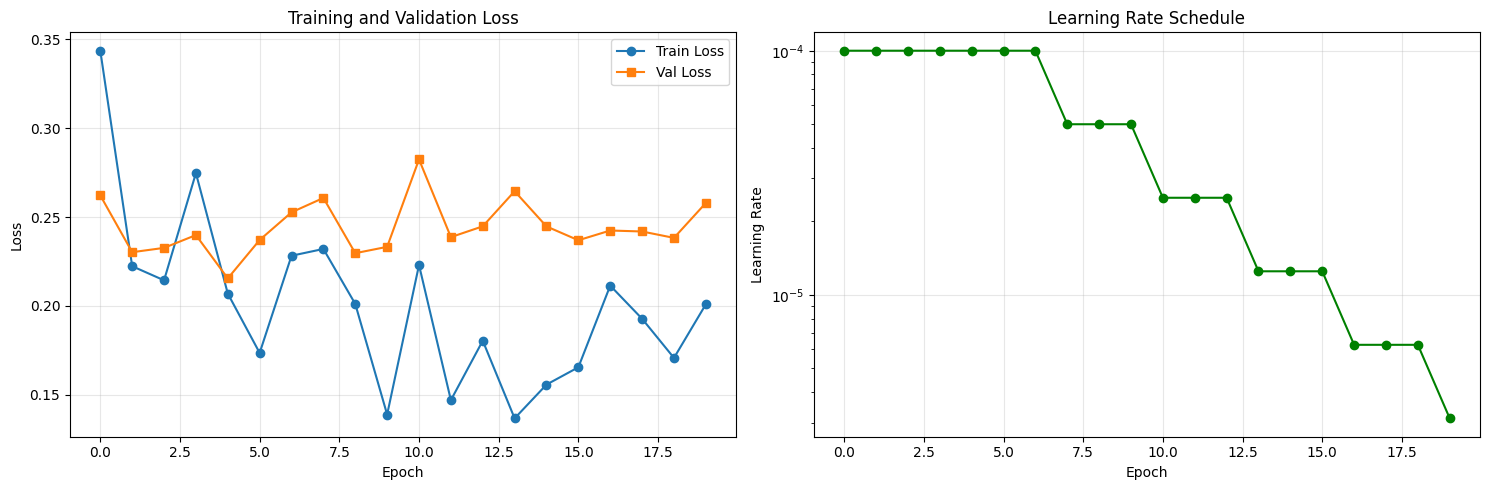


✅ Training curves saved to: /content/drive/MyDrive/SEVIR_Data/checkpoints/small_scale_test/training_curves.png


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate
axes[1].plot(history['lr'], marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/training_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Training curves saved to:", f"{CHECKPOINT_DIR}/training_curves.png")

## Step 6: Test Model Predictions

TESTING MODEL PREDICTIONS

Loaded best model from epoch 5
Validation loss: 0.215450

Prediction shape: (12, 384, 384)
Target shape: (12, 384, 384)


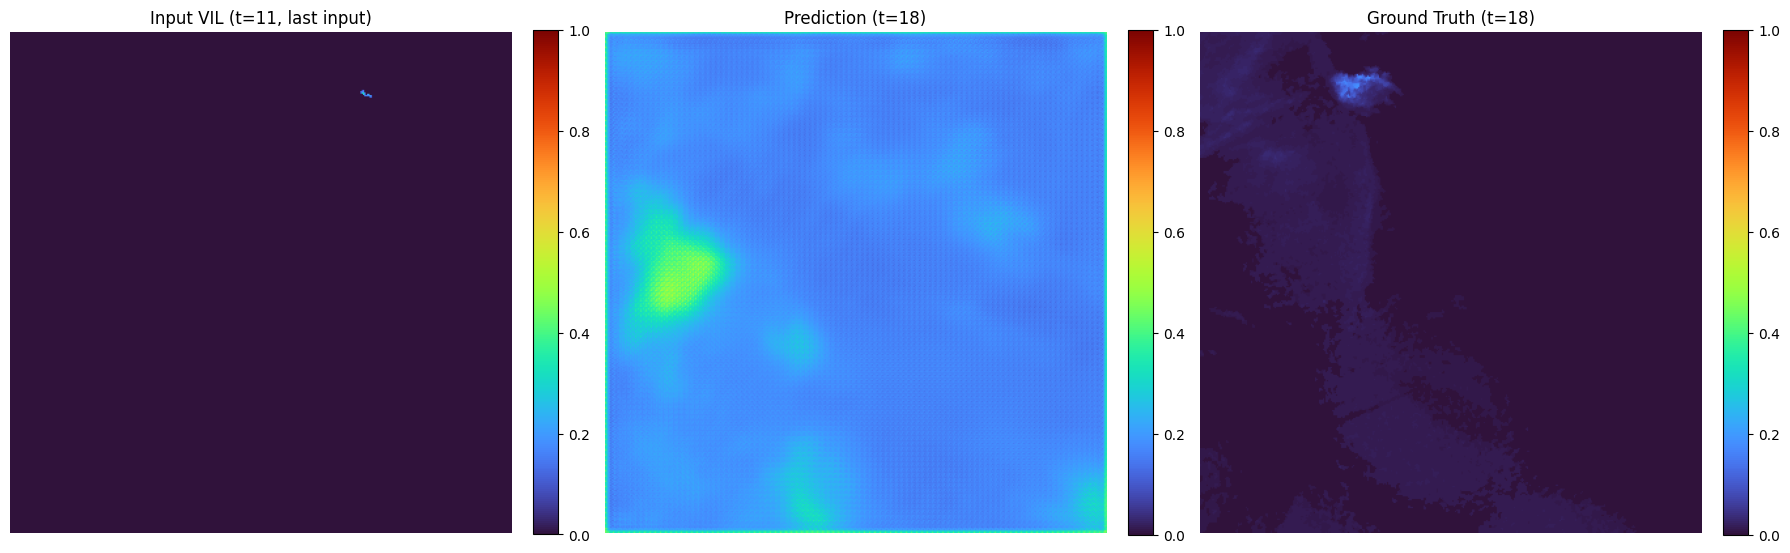


✅ Sample prediction saved to: /content/drive/MyDrive/SEVIR_Data/checkpoints/small_scale_test/sample_prediction.png



In [10]:
print("="*70)
print("TESTING MODEL PREDICTIONS")
print("="*70)

# Load best model
checkpoint = torch.load(f"{CHECKPOINT_DIR}/best_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"\nLoaded best model from epoch {checkpoint['epoch']+1}")
print(f"Validation loss: {checkpoint['val_loss']:.6f}")

# Get a validation sample
inputs, outputs_dict = val_dataset[0]

# Extract VIL target from outputs dict
targets = outputs_dict['vil']

# Add batch dimension
inputs_batch = {k: v.unsqueeze(0).to(device) for k, v in inputs.items()}

# Generate prediction (unpack tuple!)
with torch.no_grad():
    predictions, _, _ = model(inputs_batch)

# Move to CPU for visualization
predictions = predictions.cpu().squeeze(0).numpy()
targets = targets.numpy()

print(f"\nPrediction shape: {predictions.shape}")
print(f"Target shape: {targets.shape}")

# Visualize middle frame (frame 6)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

frame_idx = 6

# Input (VIL) - last input frame
vil_input = inputs['vil'][-1].numpy()  # Use last input frame
im0 = axes[0].imshow(vil_input, cmap='turbo', vmin=0, vmax=1)
axes[0].set_title(f'Input VIL (t=11, last input)')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Prediction - middle output frame
im1 = axes[1].imshow(predictions[frame_idx], cmap='turbo', vmin=0, vmax=1)
axes[1].set_title(f'Prediction (t={12+frame_idx})')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Ground truth - middle output frame
im2 = axes[2].imshow(targets[frame_idx], cmap='turbo', vmin=0, vmax=1)
axes[2].set_title(f'Ground Truth (t={12+frame_idx})')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/sample_prediction.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Sample prediction saved to:", f"{CHECKPOINT_DIR}/sample_prediction.png")
print("\n" + "="*70)

TRAINING DIAGNOSTICS

📥 Loading best model...
✅ Loaded best model from epoch 4
   Best val loss: 0.215450

🎯 CSI METRICS (on validation set):
----------------------------------------------------------------------
Computing predictions on validation set...
✅ Validation set: 12 samples, 12 timesteps

Light (VIP 16)      : CSI=0.258  Prec=0.258  Recall=1.000
Moderate (VIP 74)   : CSI=0.387  Prec=0.410  Recall=0.874
Heavy (VIP 133)     : CSI=0.172  Prec=0.175  Recall=0.905
Severe (VIP 160)    : CSI=0.051  Prec=0.052  Recall=0.752
Extreme (VIP 181)   : CSI=0.017  Prec=0.017  Recall=0.490
Hail (VIP 219)      : CSI=0.009  Prec=0.012  Recall=0.034

⏱️  PER-TIMESTEP MSE (prediction quality over time):
----------------------------------------------------------------------
  Timestep  1 (+ 5 min): MSE = 0.0557
  Timestep  2 (+10 min): MSE = 0.0515
  Timestep  3 (+15 min): MSE = 0.0526
  Timestep  4 (+20 min): MSE = 0.0554
  Timestep  5 (+25 min): MSE = 0.0527
  Timestep  6 (+30 min): MSE = 0.0560

/tmp/ipython-input-3133964451.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Saved to /content/drive/MyDrive/SEVIR_Data/checkpoints/small_scale_test/sample_predictions.png


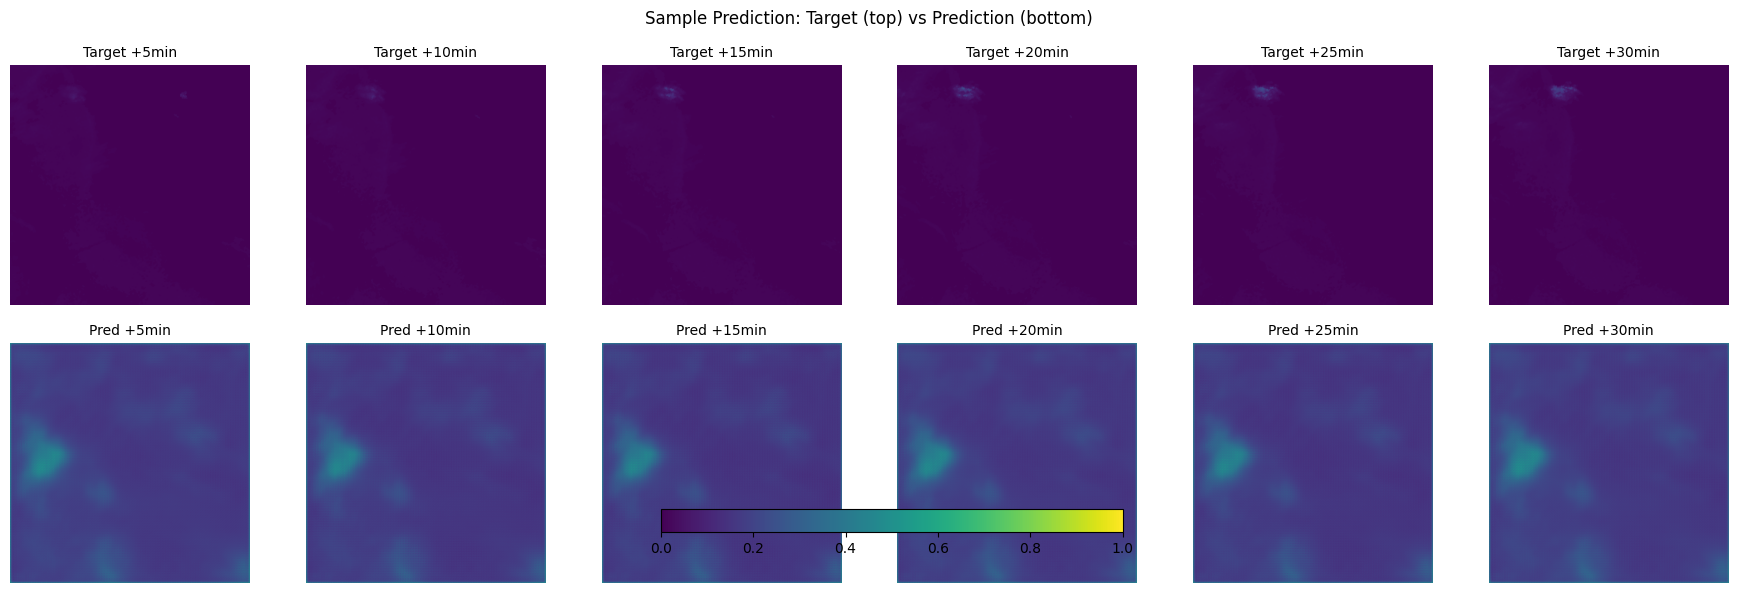


📉 PLOTTING MSE BY TIMESTEP...
✅ Saved to /content/drive/MyDrive/SEVIR_Data/checkpoints/small_scale_test/timestep_mse.png


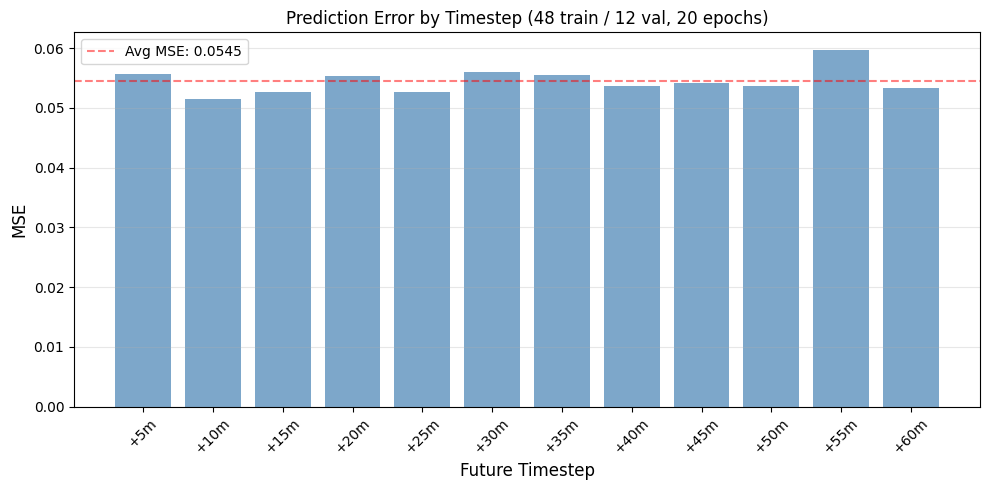


✅ DIAGNOSTICS COMPLETE

💡 KEY TAKEAWAYS:
  • Best val loss: 0.215450
  • CSI@74 (moderate): Check above
  • CSI@181 (extreme): Check above
  • Average MSE: 0.0545
  • Dataset: 48 train / 12 val events

🚀 Ready for full training (notebook 07) with 541 events!


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

print("="*70)
print("TRAINING DIAGNOSTICS")
print("="*70)

# 1. LOAD BEST MODEL
print("\n📥 Loading best model...")
checkpoint = torch.load(f"{CHECKPOINT_DIR}/best_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"✅ Loaded best model from epoch {checkpoint.get('epoch', 'unknown')}")
print(f"   Best val loss: {checkpoint.get('val_loss', 'unknown'):.6f}")

# 2. COMPUTE CSI METRICS
print("\n🎯 CSI METRICS (on validation set):")
print("-"*70)

# VIP thresholds (normalized to [0, 1] range)
thresholds = {
    'Light (VIP 16)': 16/255,
    'Moderate (VIP 74)': 74/255,
    'Heavy (VIP 133)': 133/255,
    'Severe (VIP 160)': 160/255,
    'Extreme (VIP 181)': 181/255,
    'Hail (VIP 219)': 219/255
}

all_preds = []
all_targets = []

print("Computing predictions on validation set...")
with torch.no_grad():
    for inputs, outputs_dict in val_loader:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        targets = outputs_dict['vil'].to(device)

        predictions, _, _ = model(inputs)

        all_preds.append(predictions.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds, dim=0)      # (N, T, H, W)
all_targets = torch.cat(all_targets, dim=0)  # (N, T, H, W)

print(f"✅ Validation set: {all_preds.shape[0]} samples, {all_preds.shape[1]} timesteps\n")

for name, thresh in thresholds.items():
    # Binary classification at this threshold
    pred_binary = (all_preds >= thresh).float()
    target_binary = (all_targets >= thresh).float()

    # True positives, false positives, false negatives
    tp = (pred_binary * target_binary).sum().item()
    fp = (pred_binary * (1 - target_binary)).sum().item()
    fn = ((1 - pred_binary) * target_binary).sum().item()

    # CSI = TP / (TP + FP + FN)
    csi = tp / (tp + fp + fn + 1e-8)

    # Also compute precision and recall
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)

    print(f"{name:20s}: CSI={csi:.3f}  Prec={precision:.3f}  Recall={recall:.3f}")

# 3. PER-TIMESTEP PERFORMANCE
print("\n⏱️  PER-TIMESTEP MSE (prediction quality over time):")
print("-"*70)

timestep_mse = []
for t in range(all_preds.shape[1]):
    mse_t = ((all_preds[:, t] - all_targets[:, t]) ** 2).mean().item()
    timestep_mse.append(mse_t)
    print(f"  Timestep {t+1:2d} (+{(t+1)*5:2d} min): MSE = {mse_t:.4f}")

print(f"\nAverage MSE:    {np.mean(timestep_mse):.4f}")
print(f"Best timestep:  {np.argmin(timestep_mse) + 1} (+{(np.argmin(timestep_mse)+1)*5} min, MSE = {min(timestep_mse):.4f})")
print(f"Worst timestep: {np.argmax(timestep_mse) + 1} (+{(np.argmax(timestep_mse)+1)*5} min, MSE = {max(timestep_mse):.4f})")

# 4. PREDICTION STATISTICS
print("\n📊 PREDICTION STATISTICS:")
print("-"*70)
print(f"Prediction range:  [{all_preds.min():.4f}, {all_preds.max():.4f}]")
print(f"Target range:      [{all_targets.min():.4f}, {all_targets.max():.4f}]")
print(f"Prediction mean:   {all_preds.mean():.4f}  (target: {all_targets.mean():.4f})")
print(f"Prediction std:    {all_preds.std():.4f}  (target: {all_targets.std():.4f})")

# Check extreme events
extreme_thresh = 181/255
n_extreme_target = (all_targets >= extreme_thresh).sum().item()
n_extreme_pred = (all_preds >= extreme_thresh).sum().item()
print(f"\nExtreme events (VIP≥181):")
print(f"  In targets:     {n_extreme_target:,} pixels")
print(f"  In predictions: {n_extreme_pred:,} pixels")
print(f"  Ratio:          {n_extreme_pred/max(n_extreme_target,1):.2f}x")

# 5. VISUALIZE SAMPLE PREDICTIONS
print("\n🖼️  VISUALIZING SAMPLE PREDICTIONS...")
print("-"*70)

# Get one sample
sample_idx = 0
sample_pred = all_preds[sample_idx]      # (T, H, W)
sample_target = all_targets[sample_idx]  # (T, H, W)

n_timesteps = min(6, sample_pred.shape[0])
fig, axes = plt.subplots(2, n_timesteps, figsize=(3*n_timesteps, 6))

for t in range(n_timesteps):
    # Target
    im1 = axes[0, t].imshow(sample_target[t].numpy(), cmap='viridis', vmin=0, vmax=1)
    axes[0, t].set_title(f'Target +{(t+1)*5}min', fontsize=10)
    axes[0, t].axis('off')

    # Prediction
    im2 = axes[1, t].imshow(sample_pred[t].numpy(), cmap='viridis', vmin=0, vmax=1)
    axes[1, t].set_title(f'Pred +{(t+1)*5}min', fontsize=10)
    axes[1, t].axis('off')

# Add colorbar
fig.colorbar(im1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)

plt.suptitle('Sample Prediction: Target (top) vs Prediction (bottom)', fontsize=12, y=0.98)
plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/sample_predictions.png", dpi=100, bbox_inches='tight')
print(f"✅ Saved to {CHECKPOINT_DIR}/sample_predictions.png")
plt.show()

# 6. PLOT PER-TIMESTEP MSE
print("\n📉 PLOTTING MSE BY TIMESTEP...")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(range(1, len(timestep_mse)+1), timestep_mse, color='steelblue', alpha=0.7)
ax.set_xlabel('Future Timestep', fontsize=12)
ax.set_ylabel('MSE', fontsize=12)
ax.set_title('Prediction Error by Timestep (48 train / 12 val, 20 epochs)', fontsize=12)
ax.set_xticks(range(1, len(timestep_mse)+1))
ax.set_xticklabels([f'+{(t+1)*5}m' for t in range(len(timestep_mse))], rotation=45)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=np.mean(timestep_mse), color='red', linestyle='--', alpha=0.5, label=f'Avg MSE: {np.mean(timestep_mse):.4f}')
ax.legend()

plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/timestep_mse.png", dpi=100, bbox_inches='tight')
print(f"✅ Saved to {CHECKPOINT_DIR}/timestep_mse.png")
plt.show()

print("\n" + "="*70)
print("✅ DIAGNOSTICS COMPLETE")
print("="*70)
print("\n💡 KEY TAKEAWAYS:")
print(f"  • Best val loss: {checkpoint.get('val_loss', 'N/A'):.6f}")
print(f"  • CSI@74 (moderate): Check above")
print(f"  • CSI@181 (extreme): Check above")
print(f"  • Average MSE: {np.mean(timestep_mse):.4f}")
print(f"  • Dataset: 48 train / 12 val events")
print("\n🚀 Ready for full training (notebook 07) with 541 events!")

## Summary

**What we verified:**
- ✅ Training loop works end-to-end
- ✅ Model can learn from small dataset
- ✅ Validation and checkpointing work
- ✅ Loss decreases over epochs
- ✅ Model generates reasonable predictions

**Training configuration:**
```
Dataset: 16 train events, 4 val events
Batch size: 2
Epochs: 5
Optimizer: AdamW (lr=1e-4)
Scheduler: ReduceLROnPlateau
```

**Expected behavior:**
- Training loss should decrease consistently
- Validation loss should decrease (model memorizes small dataset)
- If validation loss increases, dataset might have missing modalities

**Next steps:**
1. If training worked ✅, proceed to `07_Full_Training.ipynb`
2. That notebook will train on the full dataset
3. You'll need complete SEVIR data (from notebook 02)
4. Full training takes several hours to days depending on dataset size

---

**Troubleshooting:**
- If loss doesn't decrease: Check for missing modalities (all zeros)
- If OOM error: Reduce batch size or use gradient accumulation
- If NaN loss: Add gradient clipping (already included)
- If slow training: Check GPU utilization with `nvidia-smi`

In [ ]:
 # Check decoder activation
print(model.decoder.upsampler[-1])
# Should show: Sigmoid() not ReLU()

In [ ]:
  # Check target range
  inputs, outputs_dict = train_dataset[0]
  targets = outputs_dict['vil']

  print(f"Target shape: {targets.shape}")
  print(f"Target range: [{targets.min():.4f}, {targets.max():.4f}]")
  print(f"Target mean: {targets.mean():.4f}")
  print(f"Target dtype: {targets.dtype}")

  # Should be [0, 1] range!
  # If it's [0, 255], that's the problem!



In [ ]:
  # Check loss components during one batch
  model.eval()
  inputs, outputs_dict = next(iter(train_loader))
  inputs = {k: v.to(device) for k, v in inputs.items()}
  targets = outputs_dict['vil'].to(device)

  with torch.no_grad():
      predictions, _, physics_info = model(inputs)
      loss, loss_dict = model.compute_loss(
          predictions=predictions,
          targets=targets,
          physics_info=physics_info,
          lambda_mse=1.0,
          lambda_physics=0.1,
          lambda_extreme=2.0
      )

  print(f"\nTotal loss: {loss.item():.2f}")
  print(f"\nLoss breakdown:")
  for key, value in loss_dict.items():
      print(f"  {key}: {value:.2f}")

  print(f"\nPrediction range: [{predictions.min():.4f}, {predictions.max():.4f}]")
  print(f"Target range: [{targets.min():.4f}, {targets.max():.4f}]")